# Evaluate a Pre-Trained Segmentation Model in Colab on 2019 data


This notebook is for generating predictions on the GLNI 2019 test set and evaluating the proportion of variance ($R^2$) in live coverage, biomass, and count, explained by the predictions.

Since I do not have access to the lab analysis tables for the 2019 data, it currently performs the analysis on the training images as a demonstration, but in line comments are provided in order to make the transition to the 2019 data.

This notebook is designed to be as lean as possible, it __does not__ aim to provide interactive visualizations, for this see other notebooks, for example: `task_3_evaluate_notebook_in_colab`

__Note:__ To maintain a high priority Colab user status such that sufficient GPU resources are available in the future, ensure to free the runtime when finished running this notebook. This can be done using 'Runtime > Manage Sessions' and click 'Terminate'.

In [1]:
import sys

# Check if notebook is running in Colab or local workstation
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
    !pip install gputil
    !pip install psutil
    !pip install humanize

import GPUtil as GPU
import os
import humanize
import psutil
import sys
GPUs = GPU.getGPUs()

try:
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[1]

    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available),
              " | Proc size: " + humanize.naturalsize(process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(
            gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm()

    # Check if GPU capacity is sufficient to proceed
    if gpu.memoryFree < 5000:
        print("\nInsufficient memory! Some cells may fail. Please try restarting the runtime using 'Runtime → Restart Runtime...' from the menu bar. If that doesn't work, terminate this session and try again later.")
    else:
        print('\nGPU memory is sufficient to proceeed.')
except:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')

Gen RAM Free: 64.5 GB  | Proc size: 54.0 MB
GPU RAM Free: 11176MB | Used: 2MB | Util   0% | Total 11178MB

GPU memory is sufficient to proceeed.


In [2]:
if IN_COLAB:

    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r'/content/drive/My Drive/Data'

    # cd into git repo so python can find utils
    %cd '/content/drive/My Drive/cciw-zebra-mussel/predict'

    sys.path.append('/content/drive/My Drive')

In [3]:
import os
import os.path as osp
import csv

import glob

# for manually reading high resolution images
import cv2
import numpy as np

# for comparing predictions to lab analysis data frames
import pandas as pd

# for plotting
import matplotlib.pyplot as plt

# pytorch core library
import torch

# pytorch neural network functions
from torch import nn

from tqdm import tqdm_notebook  # notebook friendly progress bar

# evaluation metrics
from sklearn.metrics import r2_score

from task_3_utils import img_to_nchw_tensor, pretty_image

In [4]:
"""Confim that this cell prints "Found GPU, cuda". If not, select "GPU" as 
"Hardware Accelerator" under the "Runtime" tab of the main menu.
"""
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Found GPU,', device)

Found GPU, cuda


## 1. Load a pre-trained model checkpoint

In [10]:
if IN_COLAB:
    root = osp.join(
        DATA_PATH, 'Checkpoints/deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1')
    
else:
    root = osp.join(
        os.environ['DATA_PATH'], 'cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed1/checkpoint')

ckpt_file = 'deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1_epoch79.ckpt'

model_to_load = osp.join(root, ckpt_file)
                         
print('Loading', model_to_load)                         
         
checkpoint = torch.load(model_to_load)
                        
train_loss = checkpoint['trn_loss']
val_loss = checkpoint['val_loss']
print('==> Resuming from checkpoint..')
net = checkpoint['net']
last_epoch = checkpoint['epoch']
torch.set_rng_state(checkpoint['rng_state'])

# later appended to figure filenames
model_stem = ckpt_file.split('.')[0]

print('Loaded model %s trained to epoch ' % model_stem, last_epoch)
print(
    'Cross-entropy loss {:.4f} for train set, {:.4f} for validation set'.format(train_loss, val_loss))

sig = nn.Sigmoid()  # initializes a sigmoid function

net.eval()

Loading /scratch/gallowaa/cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed1/checkpoint/deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1_epoch79.ckpt
==> Resuming from checkpoint..
Loaded model deeplabv3_resnet50_lr1e-01_wd5e-04_bs40_ep80_seed1_epoch79 trained to epoch  79
Cross-entropy loss 0.1614 for train set, 0.9776 for validation set


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## 2. Set path to original, i.e., full size images

Here we manually load and preprocess the original images and png masks using OpenCV.

### Note to Dominique: set `root_path` to point to validation images after enabling 2019 tables

In [48]:
if IN_COLAB:
    # uncomment me after enabling 2019 table!
    root_path = osp.join(DATA_PATH, 'ADIG_Labelled_Dataset/val_v101/GLNI') 
    #root_path = osp.join(DATA_PATH, 'ADIG_Labelled_Dataset/train_v120/')
else:
    #root_path = '/scratch/ssd/gallowaa/cciw/VOCdevkit/Validation-v101-originals/'
    #root_path = '/scratch/ssd/gallowaa/cciw/VOCdevkit/Train-v112-originals/'
    #root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/GLNI/all-unlabelled/'
    root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/GLNI-2019-403/'
    
#jpeg_files = glob.glob(osp.join(root_path, 'JPEGImages/') + '*.jpg')
#png_files = glob.glob(osp.join(root_path, 'SegmentationClass/') + '*_crop.png')

jpeg_files = glob.glob(root_path + '*.jpg')
png_files = glob.glob(root_path + '*_crop.png')

jpeg_files.sort()
png_files.sort()

"""
Should equal 121 for train-v112
Should equal 152 for train-v120
Should equal  55 for val-v101
"""
print(len(jpeg_files))
print(len(png_files))

403
0


In [20]:
fontsize = 16

left = 0.02  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.05  # the bottom of the subplots of the figure
top = 0.95  # the top of the subplots of the figure
wspace = 0.15  # the amount of width reserved for space between subplots, expressed as a fraction of the average axis width
hspace = 0.1   # the amount of height reserved for space between subplots, expressed as a fraction of the average axis height

BIOMASS_IDX = 0
COUNT_IDX = 1
LIVE_COV_IDX = 2

## 3. Populate dataframe of lab measurements associated with `jpeg_files`

Here we predict the mussel biomass from the lab analysis using a) the masks, and b) model predictions on the 
full size images. 

In [21]:
if not IN_COLAB:

    # set DATA_PATH local machine
    DATA_PATH = osp.join(os.environ['DATA_PATH'], 'cciw/Data')
    
    # enable LaTeX style fonts only on local workstation
    import matplotlib
    matplotlib.rc('text', usetex=True)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    
    # local plotting functions
    from plot_utils import *

else:    
    # these functions are defined in plot_utils
    # but that package uses latex fonts which are incompatible with Colab
    def pretty_axis(ax, fontsize):
        ax.set_ylim(0, 1.05)
        ax.set_xlim(0, 1.05)
        ax.grid()
        ax.set_aspect('equal')
        ax.tick_params(labelsize=fontsize - 2)

    def linear_regression(x, y):
        A = np.vstack([x, np.ones(len(x))]).T
        (m, c), _, _, _ = np.linalg.lstsq(A, y, rcond=-1)
        return m * x + c

    def draw_lines(ax, x, y):
        x_ = np.linspace(0, 1)
        A = np.vstack([x, np.ones(len(x))]).T
        (m, c), res, r, s = np.linalg.lstsq(A, y, rcond=-1)
        std = np.sqrt(res[0] / len(y))
        ax.plot(x_, m * x_ + c, 'k', linestyle='-')
        ax.plot(x_, m * x_ + c + 1.96 * std, '--', color='gray')
        ax.plot(x_, m * x_ + c - 1.96 * std, '--', color='gray')


In [22]:
# the validation set has version code 101
imagetable_path = osp.join(DATA_PATH, 'Tables', '2019', 'ImageTable2019.csv')
analysis_path = osp.join(DATA_PATH, 'Tables', '2019', 'Analysis2019.csv')
dive_path = osp.join(DATA_PATH, 'Tables', '2019', 'Dives2019.csv')
'''
imagetable_path = osp.join(DATA_PATH, 'Tables', 'ImageTable.csv')
analysis_path = osp.join(DATA_PATH, 'Tables', 'Analysis.csv')
dive_path = osp.join(DATA_PATH, 'Tables', 'Dives.csv')
'''
image_df = pd.read_csv(imagetable_path, index_col=0)
analysis_df = pd.read_csv(analysis_path, index_col=0, dtype={'Count': float})
dive_df = pd.read_csv(dive_path, index_col=0, parse_dates=['Date'])
data_df = pd.merge(analysis_df, dive_df, on='Dive Index', how='outer')

In [23]:
#image_df

In [24]:
#data_df.loc[data_df['Live Coverage'].notnull()]

# 3. a) Do predictions for all images

In [25]:
model_root = ckpt_file.split('.')[0]

prediction_path = ''
for t in model_to_load.split('/')[:-1]:
    prediction_path += t + '/'
prediction_path = osp.join(prediction_path, 'predictions-403')
if not osp.exists(prediction_path):
    os.mkdir(prediction_path)
    print('Creating folder', prediction_path)
else:
    print('Folder', prediction_path, 'already exists')

Folder /scratch/gallowaa/cciw/logs/cmp-dataset/train_v120/deeplabv3_resnet50/lr1e-01/wd5e-04/bs40/ep80/seed1/checkpoint/predictions-403 already exists


In [26]:
prd_ct = []  # for storing the number of mussel pixels in each prediction

# This cell takes some time because we're randomly reading large images from Google Drive
# This loop runs at 1.5 seconds per image on my workstation.
for i in tqdm_notebook(range(len(jpeg_files)), unit=' image'):

    bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))

    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

    # pre-processing image consistent with PyTorch training transforms
    nchw_tensor = img_to_nchw_tensor(img, device)

    # saves memory in forward pass if no gradients required
    with torch.no_grad():
        pred = sig(net(nchw_tensor)['out'])
    pred_np = pred.squeeze().detach().cpu().numpy()

    prd_ct.append(pred.round().sum().item() / np.prod(pred.shape[2:]))

    '''
    plt.close('all')
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes = axes.flatten()
    axes[0].imshow(img)
    axes[0].set_title('Input', fontsize=fontsize)
    axes[1].imshow(img, alpha=0.75)
    axes[1].imshow(pred_np, alpha=0.5)
    axes[1].set_title('Input and Preds', fontsize=fontsize)
    pretty_image(axes)
    plt.tight_layout()
    #plt.show()
    image_root = jpeg_files[i].split('/')[-1].split('.')[0]
    fig.savefig(osp.join(
        prediction_path, image_root + '__' + model_root + '.jpg'))
    '''

prd_ct_np = np.asarray(prd_ct)
x_pred = prd_ct_np.copy()
# Normalize inputs between 0 and 1
x_pred = x_pred / x_pred.max()

In [27]:
#npyf = 'GLNI_2019_403_deeplabv3.npy'
npyf = 'GLNI_2019_55_deeplabv3.npy'
np.save(npyf, x_pred)
x_pred = np.load(npyf)

In [29]:
x_pred.shape

(55,)

Denote segmentation masks `x_seg_label` and predictions `x_pred`

In [49]:
# 0 = biomass, 1 = count, 2 = live coverage
lab_targets = np.zeros((len(jpeg_files), 3))

for i in range(len(jpeg_files)):

    # get unique identifier from jpeg filename which acts as a key into dataframe
    root_fname = jpeg_files[i].split(
        '/')[-1].split('.')[0].split('_image')[0].split('GLNI_')[1]

    # get a globally unique ID corresponding to image
    # get a globally unique ID corresponding to image
    try:
        guid = image_df[image_df['Image Name'].str.contains(
            root_fname)]['Analysis Index'].astype('int64')

        # extract relevant row from data frame
        row = data_df[data_df['Analysis Index'].values == np.unique(guid.values)]

        # extract Biomass, Count, and Live Coverage from row
        lab_targets[i, BIOMASS_IDX] = row['Biomass'].values
        lab_targets[i, COUNT_IDX] = row['Count'].values
        lab_targets[i, LIVE_COV_IDX] = row['Live Coverage'].values
    
    except ValueError:
        lab_targets[i, BIOMASS_IDX] = np.nan
        lab_targets[i, COUNT_IDX] = np.nan
        lab_targets[i, LIVE_COV_IDX] = np.nan   

valid_biomass = np.invert(np.isnan(lab_targets[:, BIOMASS_IDX]))
valid_count = np.invert(np.isnan(lab_targets[:, COUNT_IDX]))
valid_live_cov = np.invert(np.isnan(lab_targets[:, LIVE_COV_IDX]))

biomass = lab_targets[:, BIOMASS_IDX][valid_biomass]
count = lab_targets[:, COUNT_IDX][valid_count]
live_cov = lab_targets[:, LIVE_COV_IDX][valid_live_cov]

# Normalize targets between 0 and 1
bio_max = biomass.max()
biomass = biomass / bio_max
count_max = count.max()
count = count / count.max()
live_max = live_cov.max()
live_cov = live_cov / live_cov.max()

print('Got %d valid biomass measurements' % len(biomass))
print('Got %d valid count measurements' % len(count))
print('Got %d valid live coverage measurements' % len(live_cov))

Got 92 valid biomass measurements
Got 92 valid count measurements
Got 386 valid live coverage measurements


In [31]:
#x_pred

# Predict Live Coverage, Biomass, and Count

In [32]:
if not IN_COLAB:
    title_stem = '$\mathbf{R^2}$ = '
else:
    # no latex for Colab
    title_stem = 'R2 = '

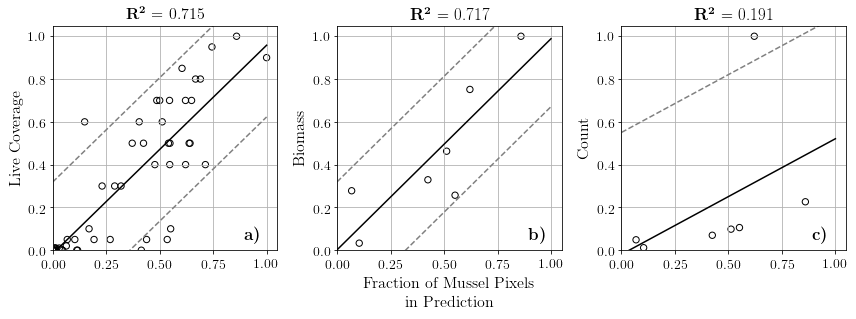

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4.5), sharex=True, sharey=False)

## live coverage ##
ax[0].scatter(x_pred[valid_live_cov], live_cov, marker='o', s=40,
              facecolors='none', edgecolors='k')
ax[0].set_ylabel('Live Coverage', fontsize=fontsize)
ax[0].set_title(title_stem + '%.3f' % r2_score(
    live_cov, linear_regression(x_pred[valid_live_cov], live_cov)), fontsize=fontsize)
draw_lines(ax[0], x_pred[valid_live_cov], live_cov)

## biomass ##
ax[1].scatter(x_pred[valid_biomass], biomass, marker='o', s=40,
              facecolors='none', edgecolors='k')
ax[1].set_ylabel('Biomass', fontsize=fontsize)
ax[1].set_xlabel('Fraction of Mussel Pixels \n in Prediction',
                 fontsize=fontsize)
ax[1].set_title(title_stem + '%.3f' % r2_score(biomass, linear_regression(
    x_pred[valid_biomass], biomass)),  fontsize=fontsize + 1)
draw_lines(ax[1], x_pred[valid_biomass], biomass)

## count ##
ax[2].scatter(x_pred[valid_count], count, marker='o',
              s=40, facecolors='none', edgecolors='k')
ax[2].set_ylabel('Count', fontsize=fontsize)
ax[2].set_title(title_stem + '%.3f' % r2_score(
    count, linear_regression(x_pred[valid_count], count)), fontsize=fontsize + 1)
draw_lines(ax[2], x_pred[valid_count], count)

if not IN_COLAB:
    draw_sublabel(ax[0], r'\textbf{a)}', fontsize, (0.85, 0.05))
    draw_sublabel(ax[1], r'\textbf{b)}', fontsize, (0.85, 0.05))
    draw_sublabel(ax[2], r'\textbf{c)}', fontsize, (0.85, 0.05))

pretty_axis(ax[0], fontsize)
pretty_axis(ax[1], fontsize)
pretty_axis(ax[2], fontsize)

plt.tight_layout()

# uncomment to save figure
#fname = 'val_v101_livecov_biomass_and_count_from_predictions_abc'
#fig.savefig(fname + '.png')
#fig.savefig(fname + '.eps', format='eps')

In [34]:
npyf = 'GLNI_2019_403_deeplabv3.npy'
xp = np.load(npyf)

In [ ]:
#fig, ax = plt.subplots(1, 1)
#power_law_prediction_ax(ax, x_pred[valid_count], count * count_max, -2, 0, fontsize)

In [ ]:
#r2_score(countin, linear_regression(x_pred[valid_count][count < 1], countin))

In [35]:
countin = count[count < 1]

In [36]:
len(countin)

6

In [37]:
def get_linear_regression_params(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    (m, c), _, _, _ = np.linalg.lstsq(A, y, rcond=-1)
    return m, c

In [38]:
m_ct, c_ct = get_linear_regression_params(x_pred[valid_count][count < 1], count[count < 1])

m_bio, c_bio = get_linear_regression_params(x_pred[valid_biomass], biomass)

m_cov, c_cov = get_linear_regression_params(x_pred[valid_live_cov], live_cov)

In [51]:
pcount = (m_ct * xp + c_ct) * count_max
pbio = (m_bio * xp + c_bio) * bio_max
pcov = (m_cov * xp + c_cov) * live_max

In [89]:
#int(pcount[0])

In [58]:
pcount = np.clip(pcount, 0, 1000)
pbio = np.clip(pbio, 0, 1000)
pcov = np.clip(pcov, 0, 100)

In [92]:
csvname = 'GLNI_2019_403_deeplabv3.csv'

with open(csvname, 'w') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow(['Image', 'Live Coverage', 'Biomass', 'Count'])
    
    for i in range(len(jpeg_files)):
        
        # get jpeg filename
        image_name = jpeg_files[i].split('/')[-1].split('.')[0].split('_crop')[0]
        
        logwriter.writerow([image_name, 
                            np.round(pcov[i], 1), 
                            np.round(pbio[i], 1),
                            int(np.round(pcount[i], 0))])

# 3. b) Load masks for all images

This will be used as a baseline when predicting live coverage, count, biomass. 

The following cell __will not__ run if using the 44 JPEG images from `Unlabeled_GLNI_OOD_Resolution` as they are unlabelled.

In [ ]:
lab_ct = []  # for storing the number of mussel pixels in each mask

# This loop should run faster as model is not used, 
# it runs at 4.5 images per second on my workstation
for i in tqdm_notebook(range(len(png_files)), unit=' image'):
    
    bgr_lab = cv2.imread(osp.join(root_path, png_files[i]))
    _, cts = np.unique(bgr_lab, return_counts=True)

    # check if mask contains both classes
    if len(cts) > 1:
        lab_ct.append(cts[1] / cts.sum())
    # or only one class (background)
    else:
        lab_ct.append(0)

lab_ct_np = np.asarray(lab_ct)        
x_seg_label = lab_ct_np.copy()
# Normalize inputs between 0 and 1
x_seg_label = x_seg_label / x_seg_label.max()

## 4. Live Coverage

From segmentation masks `x_seg_label` and predictions `x_pred`

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].scatter(x_seg_label[valid_live_cov], live_cov, marker='o',
              s=40, facecolors='none', edgecolors='k')
ax[1].scatter(x_pred[valid_live_cov], live_cov, marker='o',
              s=40, facecolors='none', edgecolors='k')

ax[0].set_ylabel('Live Coverage', fontsize=fontsize)
ax[0].set_xlabel(
    'Fraction of Mussel Pixels \n in Segmentation Mask', fontsize=fontsize)
ax[1].set_xlabel('Fraction of Mussel Pixels \n in Prediction',
                 fontsize=fontsize)

draw_lines(ax[0], x_seg_label[valid_live_cov], live_cov)
draw_lines(ax[1], x_pred[valid_live_cov], live_cov)

ax[0].set_title(title_stem + '%.3f' % r2_score(live_cov, linear_regression(
    x_seg_label[valid_live_cov], live_cov)),  fontsize=fontsize)
ax[1].set_title(title_stem + '%.3f' % r2_score(live_cov, linear_regression(
    x_pred[valid_live_cov], live_cov)),  fontsize=fontsize)

pretty_axis(ax[0], fontsize)
pretty_axis(ax[1], fontsize)

plt.tight_layout()

## 5. Biomass

From segmentation masks `x_seg_label` and predictions `x_pred`

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].scatter(x_seg_label[valid_biomass], biomass, marker='o',
              s=40, facecolors='none', edgecolors='k')
ax[1].scatter(x_pred[valid_biomass], biomass, marker='o',
              s=40, facecolors='none', edgecolors='k')
ax[0].set_ylabel('Biomass', fontsize=fontsize)
ax[0].set_xlabel(
    'Fraction of Mussel Pixels \n in Segmentation Mask', fontsize=fontsize)
ax[1].set_xlabel('Fraction of Mussel Pixels \n in Prediction',
                 fontsize=fontsize)

draw_lines(ax[0], x_seg_label[valid_biomass], biomass)
draw_lines(ax[1], x_pred[valid_biomass], biomass)

ax[0].set_title(title_stem + '%.3f' % r2_score(biomass, linear_regression(
    x_seg_label[valid_biomass], biomass)),  fontsize=fontsize)
ax[1].set_title(title_stem + '%.3f' % r2_score(
    biomass, linear_regression(x_pred[valid_biomass], biomass)),  fontsize=fontsize)

pretty_axis(ax[0], fontsize)
pretty_axis(ax[1], fontsize)

plt.tight_layout()

## 6. Count

From segmentation masks `x_seg_label` and predictions `x_pred`

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax[0].scatter(x_seg_label[valid_count], count, marker='o',
              s=40, facecolors='none', edgecolors='k')
ax[1].scatter(x_pred[valid_count], count, marker='o',
              s=40, facecolors='none', edgecolors='k')
ax[0].set_ylabel('Count', fontsize=fontsize)
ax[0].set_xlabel(
    'Fraction of Mussel Pixels \n in Segmentation Mask', fontsize=fontsize)
ax[1].set_xlabel('Fraction of Mussel Pixels \n in Prediction',
                 fontsize=fontsize)

draw_lines(ax[0], x_seg_label[valid_count], count)
draw_lines(ax[1], x_pred[valid_count], count)

ax[0].set_title(title_stem + '%.3f' % r2_score(
    count, linear_regression(x_seg_label[valid_count], count)),  fontsize=fontsize)
ax[1].set_title(title_stem + '%.3f' % r2_score(
    count, linear_regression(x_pred[valid_count], count)),  fontsize=fontsize)

pretty_axis(ax[0], fontsize)
pretty_axis(ax[1], fontsize)

plt.tight_layout()

# Optionally evaluate on out-of-distribution resolution for testing robustness

These GLNI 2019 images are from a 3788x6738 pixel source instead of the 4924x7378 pixels used for training. They are unlabeled, but suitable for testing against lab analysis.

After running this cell go back to step 3. a), but do not 3. b).

In [ ]:
if IN_COLAB:
    root_path = osp.join(DATA_PATH, 'ADIG_Labelled_Dataset/val_v101/Unlabeled_GLNI_OOD_Resolution/') 
    jpeg_files = glob.glob(root_path + '*.jpg')
else:
    root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/GLNI/Unlabeled_GLNI_OOD_Resolution/'
    jpeg_files = glob.glob(root_path + '*.jpg')

jpeg_files.sort()    
print(len(jpeg_files)) # should equal 44

### Plot predictions 

Predictions are saved into the same folder as the checkpoint.

In [ ]:
for i in tqdm_notebook(range(len(jpeg_files)), unit=' image'):

    image_root = jpeg_files[i].split('/')[-1].split('.')[0]

    bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))

    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

    # pre-processing image consistent with PyTorch training transforms
    nchw_tensor = img_to_nchw_tensor(img, device)

    # saves memory in forward pass if no gradients required
    with torch.no_grad():
        pred = sig(net(nchw_tensor)['out'])
    pred_np = pred.squeeze().detach().cpu().numpy()

    image = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

    plt.close('all')
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes = axes.flatten()
    axes[0].imshow(image)
    axes[0].set_title('Input', fontsize=fontsize)
    axes[1].imshow(image, alpha=0.75)
    axes[1].imshow(pred_np, alpha=0.5)
    axes[1].set_title('Input and Preds', fontsize=fontsize)
    pretty_image(axes)
    plt.tight_layout()
    plt.show()

    fig.savefig(osp.join(prediction_path, image_root +
                         '__' + model_root + '.jpg'))